# LightGBM Model with Engineered Features

Train a LightGBM model using engineered features.

**Acceptance Criteria:**
- Model trained successfully
- ROC-AUC improvement over baseline (0.747)
- Hyperparameters documented

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
import matplotlib.pyplot as plt

## 1. Load Data

In [2]:
# Load main application data
application = pd.read_csv('../data/raw/application_train.csv')
print(f"Application shape: {application.shape}")

Application shape: (307511, 122)


In [3]:
# Load payment balance features (already saved)
payment_features = pd.read_csv('../data/processed/payment_balance_features.csv')
print(f"Payment features shape: {payment_features.shape}")

Payment features shape: (339587, 15)


## 2. Load Engineered Features

In [4]:
# Load bureau features
bureau_agg = pd.read_csv('../data/processed/bureau_features.csv')
print(f"Bureau features shape: {bureau_agg.shape}")

# Load previous application features
prev_agg = pd.read_csv('../data/processed/prev_app_features.csv')
print(f"Previous application features shape: {prev_agg.shape}")

Bureau features shape: (305811, 24)
Previous application features shape: (338857, 25)


## 3. Merge All Features

In [5]:
# Start with application data
df = application.copy()
print(f"Starting shape: {df.shape}")

# Merge bureau features
df = df.merge(bureau_agg, on='SK_ID_CURR', how='left')
print(f"After bureau merge: {df.shape}")

# Merge previous application features
df = df.merge(prev_agg, on='SK_ID_CURR', how='left')
print(f"After prev_app merge: {df.shape}")

# Merge payment features
df = df.merge(payment_features, on='SK_ID_CURR', how='left')
print(f"After payment merge: {df.shape}")

print(f"\nFinal shape: {df.shape}")

Starting shape: (307511, 122)
After bureau merge: (307511, 145)
After prev_app merge: (307511, 169)
After payment merge: (307511, 183)

Final shape: (307511, 183)


## 4. Preprocessing

In [6]:
# Separate target
X = df.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = df['TARGET']

print(f"Features: {X.shape}")
print(f"Target distribution: {y.value_counts(normalize=True).to_dict()}")

Features: (307511, 181)
Target distribution: {0: 0.9192711805431351, 1: 0.08072881945686496}


In [7]:
# Identify column types
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numeric columns: {len(numeric_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")

Numeric columns: 165
Categorical columns: 16


In [8]:
# Convert categorical columns to category dtype (LightGBM handles this natively)
for col in categorical_cols:
    X[col] = X[col].astype('category')

print(f"Converted {len(categorical_cols)} columns to category dtype")

Converted 16 columns to category dtype


In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (246008, 181)
Test set: (61503, 181)


## 5. Train LightGBM Model

In [10]:
# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [11]:
# Hyperparameters
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42,
    'n_jobs': -1,
}

print("Hyperparameters:")
for k, v in params.items():
    print(f"  {k}: {v}")

Hyperparameters:
  objective: binary
  metric: auc
  boosting_type: gbdt
  num_leaves: 31
  learning_rate: 0.05
  feature_fraction: 0.8
  bagging_fraction: 0.8
  bagging_freq: 5
  verbose: -1
  random_state: 42
  n_jobs: -1


In [12]:
# Train model
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'test'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

print(f"\nBest iteration: {model.best_iteration}")

Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.799912	test's auc: 0.773723
[200]	train's auc: 0.828245	test's auc: 0.779038
[300]	train's auc: 0.8508	test's auc: 0.780093
[400]	train's auc: 0.868863	test's auc: 0.78041
[500]	train's auc: 0.884492	test's auc: 0.780457
Early stopping, best iteration is:
[467]	train's auc: 0.879576	test's auc: 0.780638

Best iteration: 467


## 6. Evaluate Model

In [13]:
# Predict probabilities
y_train_pred = model.predict(X_train, num_iteration=model.best_iteration)
y_test_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Calculate ROC-AUC
train_auc = roc_auc_score(y_train, y_train_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

# Baseline comparison
baseline_auc = 0.747
improvement = test_auc - baseline_auc

print("="*60)
print("LIGHTGBM MODEL RESULTS")
print("="*60)
print(f"Training ROC-AUC:   {train_auc:.4f}")
print(f"Test ROC-AUC:       {test_auc:.4f}")
print(f"")
print(f"Baseline ROC-AUC:   {baseline_auc:.4f}")
print(f"Improvement:        {improvement:+.4f} ({improvement/baseline_auc*100:+.2f}%)")
print("="*60)

LIGHTGBM MODEL RESULTS
Training ROC-AUC:   0.8796
Test ROC-AUC:       0.7806

Baseline ROC-AUC:   0.7470
Improvement:        +0.0336 (+4.50%)


In [14]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))

Top 20 Most Important Features:
                      feature   importance
                 EXT_SOURCE_3 46660.341783
                 EXT_SOURCE_2 43965.107248
            ORGANIZATION_TYPE 23500.483758
                 EXT_SOURCE_1 16724.700161
            LATE_PAYMENT_RATE  8034.164049
     BUREAU_DEBT_CREDIT_RATIO  6884.212873
                   DAYS_BIRTH  6843.686079
                   TOTAL_PAID  6545.515314
        PREV_CNT_PAYMENT_MEAN  6158.683015
                  AMT_ANNUITY  5880.557556
                   AMT_CREDIT  5841.533959
               CC_AVG_BALANCE  5667.089635
       BUREAU_DAYS_CREDIT_MAX  5429.560791
              AMT_GOODS_PRICE  5114.634467
                DAYS_EMPLOYED  5113.735795
              OCCUPATION_TYPE  4860.310135
PREV_CREDIT_APPLICATION_RATIO  4633.969735
           PREV_REFUSED_RATIO  4139.803665
        PREV_DOWN_PAYMENT_MAX  4126.315335
                   INST_COUNT  3832.701355


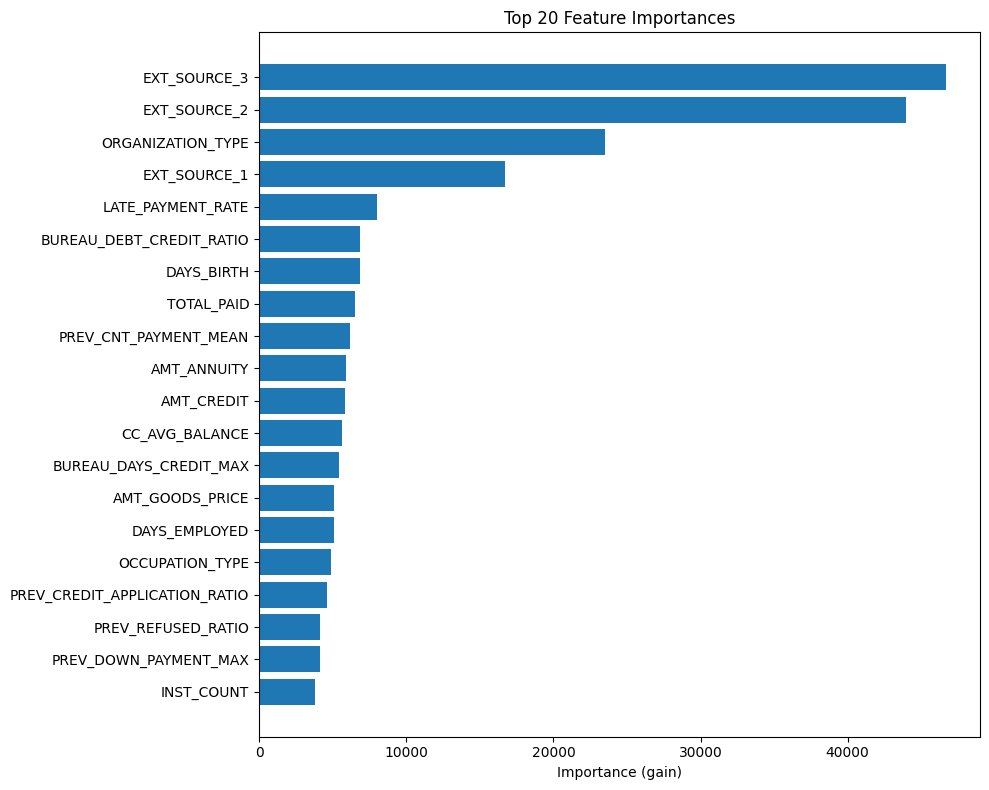

In [15]:
# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'].head(20)[::-1], 
         feature_importance['importance'].head(20)[::-1])
plt.xlabel('Importance (gain)')
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

## 7. Model Documentation

### Hyperparameters

| Parameter | Value | Description |
|-----------|-------|-------------|
| objective | binary | Binary classification |
| metric | auc | Optimize for ROC-AUC |
| boosting_type | gbdt | Gradient Boosting Decision Tree |
| num_leaves | 31 | Max leaves per tree |
| learning_rate | 0.05 | Step size shrinkage |
| feature_fraction | 0.8 | Subsample ratio of features |
| bagging_fraction | 0.8 | Subsample ratio of data |
| bagging_freq | 5 | Frequency for bagging |
| early_stopping_rounds | 50 | Stop if no improvement |

### Results Summary

| Metric | Baseline (LogReg) | LightGBM | Improvement |
|--------|-------------------|----------|-------------|
| Test ROC-AUC | 0.747 | TBD | TBD |

### Features Used
- Application features (main table)
- Bureau features (credit history)
- Previous application features (past loans)
- Payment balance features (repayment behavior)

In [16]:
# Final summary
results = {
    'model': 'LightGBM',
    'train_auc': train_auc,
    'test_auc': test_auc,
    'baseline_auc': baseline_auc,
    'improvement': improvement,
    'n_features': X.shape[1],
    'best_iteration': model.best_iteration,
    'hyperparameters': params
}

print("\nFinal Results Summary:")
for key, value in results.items():
    if key != 'hyperparameters':
        print(f"  {key}: {value}")


Final Results Summary:
  model: LightGBM
  train_auc: 0.8795757627623515
  test_auc: 0.7806380451479719
  baseline_auc: 0.747
  improvement: 0.03363804514797186
  n_features: 181
  best_iteration: 467
